In [1]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = '/githome/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))
now = str(current_milli_time())

def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def normalize(data,column="Close",deci = False):
    """
    Function for simple time series normalization 
    """
    if(deci==True):
        norm_close =  data[column].divide(data[column].iloc[0])-1
    else:
        norm_close =  data[column].divide(data[column].iloc[0])
    return norm_close


def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    """
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
    """    
    return fs

def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))    

In [2]:
#get freq. signal df
fs = get_freq_sig(bw_location)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
print(fs_c.head(3))
print(fs_c.tail(3))
#Create start and end for interval dataframe 
st,end = fs_c.index[0][0],fs_c.index[-1][0]
st,end = unix_time_millis(st),unix_time_millis(end)

#30d interval for portfolio generation
intv = 30
#make multiindex frequency dataframe 
#works on fs_c
freq_df,intv_list = interval(intv,st,end)
#group by Coin
cgroups = freq_df.groupby('Coin')
#make list of all syms/dates in dataframe.... the index
coins = list(freq_df.index.get_level_values('Coin').drop_duplicates())
dates = list(freq_df.index.get_level_values('Date').drop_duplicates())

print(coins)
#test print of grouped dataframe
coin = cgroups.get_group(coins[0])
print(coin.tail())

0% of files loaded
2018-08-24 00:09:22.289000 2019-01-09 20:29:18.353000
2019-01-16 16:45:04.221000 1547675104221
12910    1535083762289
26862    1535084106238
6593     1535084444624
14510    1535084787792
20870    1535085130313
Name: 0, dtype: int64
87269 87269
                                 Close         Date_m  rolling_freq
Date                Coin                                           
2018-08-24 04:09:22 ENGBTC    0.000099  1535083762289             1
                    DASHBTC   0.021344  1535083762289             1
2018-08-24 04:15:06 THETABTC  0.000015  1535084106238             1
                                Close         Date_m  rolling_freq
Date                Coin                                          
2019-01-10 01:29:18 AGIBTC   0.000013  1547083758353           700
                    GXSBTC   0.000143  1547083758353           760
                    PIVXBTC  0.000221  1547083758353          1385
2018-08-24   |   2018-09-23
2018-09-23   |   2018-10-23
2018-1

,,Close,Date_m,rolling_freq
Date,Coin,,,
2018-08-24 04:09:22,DASHBTC,0.021344,1535083762289,1
2018-08-24 04:32:10,DASHBTC,0.021321,1535085130313,2
2018-08-24 04:37:52,DASHBTC,0.021328,1535085472239,3
2018-08-24 10:01:29,DASHBTC,0.021227,1535104889339,4
2018-08-24 10:07:11,DASHBTC,0.021227,1535105231536,5
2018-08-24 10:18:33,DASHBTC,0.021227,1535105913441,6
2018-08-24 10:24:08,DASHBTC,0.021287,1535106248919,7
2018-08-24 11:04:06,DASHBTC,0.021226,1535108646388,8
2018-08-24 11:09:55,DASHBTC,0.021280,1535108995600,9


# BW freq signal visualization

-used time delta between singal events for smoothing signal and creating tradable actions

1541 28535


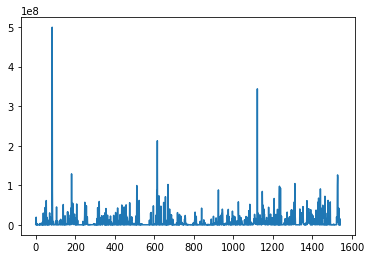

In [3]:
#print(coins)
#utc intervals for ranking event/possible event weighting
d = 86400
h = int(d/24)
hhr = int(h/17)
print(len(coin),len(dates))

t_dif = []
for i in range(0,len(coin)-1):
    t1 = coin['Date_m'].iloc[i]
    t2 = coin['Date_m'].iloc[i+1]
    td = (t2-t1)
    #if(td) signal logic
    t_dif.append(td)
t_dif.append(0)
t_dif_x = [x for x in range(len(t_dif))]
plt.plot(t_dif_x,t_dif)

plt.show()

## Daily resampling for signal/event generation

### creates a dataframe for all coins w/ signals for trading/backtesting
Makes a single csv w/ all coins and multilevel indexing by portfolio time
https://alphascientist.com/feature_engineering.html

c_hist is feature df

In [62]:
all_coins = pd.DataFrame()
for sym in coins:
    coin = cgroups.get_group(sym)
    
    #the secret sauce, extracting value from our data
    #for this example im using the time difference between the signal event occurence to determine enter/exits
    t_dif = []
    for i in range(0,len(coin)-1):
        t1 = coin['Date_m'].iloc[i]
        t2 = coin['Date_m'].iloc[i+1]
        td = (t2-t1)
        #if(td) signal logic
        t_dif.append(td)
    t_dif.append(0)
    #print(t_dif==coin['t_diff'])
    coin = coin.assign(t_dif = t_dif)
    coin.t_dif = coin.t_dif.shift(1)
    
    coin = coin.fillna(method='bfill')
    coin.t_dif = coin.t_dif.pct_change()
    coin = coin[['Close','t_dif']].copy()
    coin.Close = normalize(coin)
    coin.fillna(method='bfill')
    
    #make copy w/ no index for resample and hist data sync
    #create daily signals from intraday signal dataset
    dc = coin.reset_index().copy()
    dc.index = dc.Date
    #Daily resample
    daily_coin = dc.resample('D').sum()
    
    #daily resampled date index
    dates = list(daily_coin.index)
    print(sym)
    print(dates[0].strftime('%Y-%m-%d'),"   |   ",dates[-1].strftime('%Y-%m-%d'))
    prev_k,k = int(dates[0].timestamp()*1000), int(dates[-1].timestamp()*1000)
    
    #Download historical data
    c_hist = get_data(sym,prev_k,k,candle_k='1d')
    
    #extract signal for resampled signal dataframe and create signal column (-1,1) ...maybe (-1,0,1)
    c_hist['Close_diff'] = c_hist['Close'].diff().apply(np.sign)
    
    # log of 5 day moving average of volume

    c_hist['5dlv'] = c_hist.Volume.rolling(5).mean().apply(np.log) 

    # daily volume vs. 200 day moving average

    c_hist['v_3v'] = c_hist.Volume/ c_hist.Volume.rolling(3).mean()-1

    
    c_hist['bw_sig'] = daily_coin.t_dif
    c_hist['sig3'] = c_hist["bw_sig"].apply(np.sign)
    c_hist['sig3'] = c_hist['sig3'].replace(0,-1)
    c_hist = c_hist.fillna(0) 
    c_hist["daily_returns"] = (c_hist['Close']/c_hist['Open'])-1
    """
    #Visualize trading range and signal
    c_hist2 = c_hist[["Close","sig3"]].copy()
    c_hist2.Close = normalize(c_hist2,deci=True)
    c_hist2["High"] = normalize(c_hist,column="High",deci=True)
    c_hist2["Low"] = normalize(c_hist,column="Low",deci=True)
    c_hist2.plot(figsize=(8,5))
    #plt.savefig("/home/me/Pictures/{}range_signal.png".formate(sym))
    
    c_hist[['sig3','Close_diff']].plot(grid=True,figsize=(8,5))
    """


    c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
    c_hist['Strategy Returns'] = c_hist['Market Returns'] * c_hist['sig3'].shift(1)
    c_hist['Coin'] = sym
    c_hist = c_hist.reset_index()
    c_hist = c_hist.set_index(['Open time','Coin'])

    all_coins = pd.concat([all_coins,c_hist])
    
#dts is dates for resampled df
dts = all_coins.index.get_level_values(0)

fol = dts[0].strftime('%Y-%m-%d')+"_"+dts[-1].strftime('%Y-%m-%d')
print(fol)
#save all_coin to csv
fname = '/home/me/Documents/BWA/data/bw_portfolios/{}'.format(fol)
if os.path.exists(fname) == False:
    os.mkdir(fname)
    all_coins.to_csv(fname+"{}_day_int.csv".format("30"))

all_coins

ADABTC
2018-09-11    |    2018-12-31
ADXBTC
2018-08-28    |    2019-01-08
AEBTC
2018-08-24    |    2019-01-07
AGIBTC
2018-08-26    |    2019-01-10
AIONBTC
2018-08-24    |    2019-01-07
AMBBTC
2018-08-24    |    2019-01-09
APPCBTC
2018-08-24    |    2019-01-07
ARDRBTC
2018-08-24    |    2019-01-09
ARKBTC
2018-08-24    |    2019-01-09
ARNBTC
2018-08-24    |    2019-01-09
ASTBTC
2018-08-27    |    2019-01-07
BATBTC
2018-08-24    |    2019-01-09
BCCBTC
2018-08-25    |    2018-11-15
BCDBTC
2018-09-04    |    2018-12-18
BCPTBTC
2018-08-24    |    2019-01-07
BLZBTC
2018-08-24    |    2019-01-08
BNBBTC
2018-08-24    |    2019-01-08
BNTBTC
2018-08-26    |    2019-01-07
BQXBTC
2018-08-24    |    2019-01-09
BRDBTC
2018-08-27    |    2019-01-08
BTGBTC
2018-08-24    |    2019-01-09
BTSBTC
2018-08-26    |    2019-01-07
CDTBTC
2018-09-05    |    2018-11-29
CHATBTC
2018-08-24    |    2018-10-19
CLOAKBTC
2018-08-24    |    2019-01-08
CMTBTC
2018-08-24    |    2019-01-04
CNDBTC
2018-09-05    |    2019-0

,,Open,High,Low,Close,Close time,Volume,Close_diff,5dlv,v_3v,bw_sig,sig3,daily_returns,Market Returns,Strategy Returns
Open time,Coin,,,,,,,,,,,,,,
2018-09-11,ADABTC,0.000012,0.000012,0.000011,0.000011,1.536710e+12,135238005.0,0.0,0.000000,0.000000,0.000000,-1.0,-0.043814,NaN,NaN
2018-09-12,ADABTC,0.000011,0.000011,0.000010,0.000010,1.536797e+12,242988139.0,-1.0,0.000000,0.000000,0.000000,-1.0,-0.061041,-0.062086,0.062086
2018-09-13,ADABTC,0.000010,0.000011,0.000010,0.000011,1.536883e+12,227149368.0,1.0,0.000000,0.125662,0.000000,-1.0,0.022945,0.022685,-0.022685
2018-09-14,ADABTC,0.000011,0.000011,0.000010,0.000010,1.536970e+12,160515073.0,-1.0,0.000000,-0.236433,0.000000,-1.0,-0.027052,-0.025557,0.025557
2018-09-15,ADABTC,0.000010,0.000011,0.000010,0.000011,1.537056e+12,90471731.0,1.0,18.958766,-0.432348,0.000000,-1.0,0.013436,0.012387,-0.012387
2018-09-16,ADABTC,0.000011,0.000011,0.000010,0.000011,1.537142e+12,96655580.0,1.0,18.912666,-0.165905,0.000000,-1.0,0.017029,0.017832,-0.017832
2018-09-17,ADABTC,0.000011,0.000011,0.000010,0.000010,1.537229e+12,135630448.0,-1.0,18.771932,0.260671,0.000000,-1.0,-0.054884,-0.056447,0.056447
2018-09-18,ADABTC,0.000010,0.000011,0.000010,0.000011,1.537315e+12,190202129.0,1.0,18.718523,0.350586,0.000000,-1.0,0.071921,0.068468,-0.068468
2018-09-19,ADABTC,0.000011,0.000012,0.000011,0.000011,1.537402e+12,275089319.0,1.0,18.875633,0.373336,0.000000,-1.0,0.036731,0.036991,-0.036991


# Plotting correlation heatmap for all coins.
Used for feature engineering

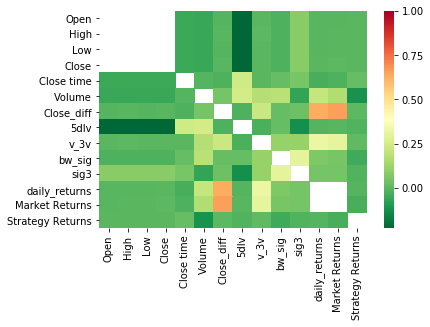

In [63]:
#cgroups = all_coins.groupby('Coin')
corr = all_coins.corr()
#print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn_r', mask = (corr >= 0.9))

# Show overall perfomance of signal strategy vs BTC benchmark

In [6]:
#Download BTC hist data for benchmark
bench = get_data("BTCUSDT",int(unix_time_millis(dts[0])),int(unix_time_millis(dts[-1])),"1d")

BW Portfolio Returns:

| Avg buy 'n hold: -0.1226762152976343% 
| BW Strategy: 0.2468068626929229% 
| BTC -0.5214415566383174% 

Performance w/ 10,000 starting value

| Avg buy 'n hold: $3558 
| BW Strategy: $7253
| BTC hold $4785


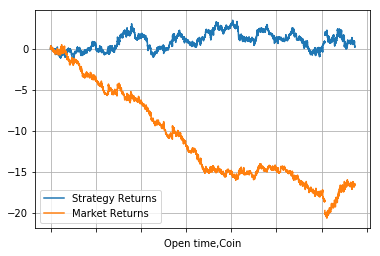

In [7]:
#starting capital
cap = 10000
#make log btc returns
btc = np.log(bench['Close'] / bench['Close'].shift(1))

btc_returns = btc.cumsum().iloc[-1]
s_returns = all_coins['Strategy Returns'].cumsum().iloc[-1]
m_returns = (all_coins['Market Returns'].cumsum().iloc[-1]/len(coins))

#hypothetical returns per strategy
s_value = cap+(cap*s_returns)
m_value = cap+(cap*m_returns)

#hypothetical growth of 10k
btc_value = int(cap+(cap*btc_returns)) 
s_value_usd = int(cap+(cap*(s_returns+btc_returns)))
m_value_usd = int(cap+(cap*(m_returns+btc_returns)))


print("BW Portfolio Returns:\n\n| Avg buy 'n hold: {}% \n| BW Strategy: {}% \n| BTC {}% \n".format(m_returns,s_returns,btc_returns))
print("Performance w/ 10,000 starting value\n\n| Avg buy 'n hold: ${} \n| BW Strategy: ${}\n| BTC hold ${}".format(m_value_usd,s_value_usd,btc_value))
total_returns = all_coins[['Strategy Returns','Market Returns']].cumsum().plot(grid=True)

In [67]:
import bt
#bt strategy

hold = bt.Strategy('hold', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

hist_stack = []
sig_stack = []
vol_stack = []
pt = "============================"
all_coins = all_coins.sort_values('Open time')
ac_groups = all_coins.groupby('Coin')
for c,t in enumerate(intv_list):
    #1 interval hist dataframe
    bt_hist_data = pd.DataFrame()
    bt_sig_data = pd.DataFrame()
    bt_vol_data = pd.DataFrame()
    #get start and end dates for interval
    try:
        n = intv_list[c+1]
    except:
        break
    
    print("Portfolio from {} to {} \n{}".format(t,n,pt))
    
    #create copy of df with index selection
    curr = all_coins.loc[t:n].copy()
    curr = curr.reset_index()#.drop_duplicates()
    #list of coin
    coins = curr['Coin'].drop_duplicates()
    curr.index = curr["Open time"]
    idex = curr["Open time"]
    cg = curr.groupby('Coin')
    
    i=0
    prev_len = []
    c_bt = []
    for c in coins:
        curr = cg.get_group(c)
        #print(curr)

        if(i==0):
            prev_len.append(len(curr))

        if(len(curr) == prev_len[len(prev_len)-2]):
            #print(bt_hist_data)
            try:
                bt_hist_data[c] = curr.Close.values
                bt_sig_data[c] = curr.sig3.values
                bt_vol_data[c] = curr['5dlv'].values
                
                bt_hist_data.index = curr.index
                bt_sig_data.index = curr.index
                bt_vol_data.index = curr.index
                prev_len.append(len(curr))
            except Exception as e:
                pass
            
        #bt_hist_data.index = idex.drop_duplicates()  
        #bt_hist_data
        #cont = input("Run backtest? y/n: ")
        #if(cont=='y'):
        #bt_hist_data['Signal'] = curr.sig3
        if(i<2):
            print(bt_hist_data.head())
        i+=1

            
           
    #Monthly holding backtest
    hist_stack.append(bt_hist_data)
    sig_stack.append(bt_sig_data)
    vol_stack.append(bt_vol_data)
    """
    test = bt.Backtest(hold, bt_hist_data)
    res = bt.run(test)
    res.plot(grid=True)
    res.display()
    plt.show()
    """
    



Portfolio from 2018-08-24 00:00:00 to 2018-09-23 00:00:00 
              ENGBTC
Open time           
2018-08-24  0.000105
2018-08-25  0.000104
2018-08-26  0.000116
2018-08-27  0.000117
2018-08-28  0.000118
              ENGBTC   ARDRBTC
Open time                     
2018-08-24  0.000105  0.000017
2018-08-25  0.000104  0.000017
2018-08-26  0.000116  0.000016
2018-08-27  0.000117  0.000016
2018-08-28  0.000118  0.000017
Portfolio from 2018-09-23 00:00:00 to 2018-10-23 00:00:00 
             LENDBTC
Open time           
2018-09-23  0.000002
2018-09-24  0.000002
2018-09-25  0.000002
2018-09-26  0.000002
2018-09-27  0.000002
             LENDBTC   AIONBTC
Open time                     
2018-09-23  0.000002  0.000069
2018-09-24  0.000002  0.000066
2018-09-25  0.000002  0.000064
2018-09-26  0.000002  0.000063
2018-09-27  0.000002  0.000064
Portfolio from 2018-10-23 00:00:00 to 2018-11-21 00:00:00 
             NANOBTC
Open time           
2018-10-23  0.000309
2018-10-24  0.000313
2018-10-25 

In [68]:
#all coin hist data concatenated
all_c = pd.concat(hist_stack,sort=True)
#all coin signals concatenated
all_sig = pd.concat(sig_stack,sort=True)
#all 3d vol vs vol concatenated
all_vol = pd.concat(vol_stack,sort=True)
#add "0" values for no possible position
all_sig = all_sig.fillna(0)
#print(all_c.iloc[0:2])
#print(all_sig.iloc[0:2])
#save/update signal df for live trading
fname = "/home/me/Documents/BWA/data/bw_signal.csv"
all_sig.to_csv(fname)

# Test daily universe selection/weights and trade targets

-Possible features to look for: volatility, inv vol, momentum
-Most simple possibility is to use volume as ranking. Volume is strongly correlationed to strategy returns

In [122]:
#loop through datetime index
n=0
for i in all_c.index:
    print("\n",i,"\n",pt)
    milli_index = unix_time_millis(i)

    #bool value for if buy signal
    sig = all_sig.loc[i]
    vol = all_vol.loc[i]
    hist = all_c.loc[i]
    try:
        daily_vol = vol.sort_values(ascending=False)
        port = list(daily_vol.head(8).index)
        d_port = pd.DataFrame(hist.loc[port].values,sig.loc[port].values)
        d_port['Coin'] = port
        #d_port.index = port
        print(d_port)
        #print(port)
    except:
        pass
    #print(daily_vol.head(8))
    


 2018-08-24 00:00:00 
             0    Coin
 1.0  0.000109  ZRXBTC
 1.0  0.000013  GTOBTC
 1.0  0.000056  ELFBTC
 1.0  0.000105  ENGBTC
-1.0  0.042050  ETHBTC
-1.0  0.000067  EVXBTC
-1.0  0.000850  GASBTC
 1.0  0.000092  GRSBTC

 2018-08-25 00:00:00 
             0    Coin
 1.0  0.000106  ZRXBTC
 1.0  0.000012  GTOBTC
 1.0  0.000057  ELFBTC
 1.0  0.000104  ENGBTC
 1.0  0.041225  ETHBTC
-1.0  0.000065  EVXBTC
 1.0  0.000828  GASBTC
 1.0  0.000091  GRSBTC

 2018-08-26 00:00:00 
             0    Coin
 1.0  0.000106  ZRXBTC
 1.0  0.000012  GTOBTC
-1.0  0.000058  ELFBTC
 1.0  0.000116  ENGBTC
-1.0  0.040912  ETHBTC
-1.0  0.000063  EVXBTC
-1.0  0.000860  GASBTC
 1.0  0.000090  GRSBTC

 2018-08-27 00:00:00 
            0    Coin
1.0  0.000117  ZRXBTC
1.0  0.000013  GTOBTC
1.0  0.000063  ELFBTC
1.0  0.000117  ENGBTC
1.0  0.041670  ETHBTC
1.0  0.000066  EVXBTC
1.0  0.001007  GASBTC
1.0  0.000090  GRSBTC

 2018-08-28 00:00:00 
             0      Coin
 1.0  0.000015    CMTBTC
-1.0  0.000015  

-1.0  0.000006   VIBBTC

 2018-09-29 00:00:00 
             0     Coin
 1.0  0.000086   XRPBTC
-1.0  0.000013   ADABTC
 1.0  0.000007   OSTBTC
-1.0  0.000007   QKCBTC
-1.0  0.000009   ENJBTC
-1.0  0.000003  DOCKBTC
-1.0  0.000039   XLMBTC
-1.0  0.000006   VIBBTC

 2018-09-30 00:00:00 
             0     Coin
 1.0  0.000088   XRPBTC
-1.0  0.000013   ADABTC
-1.0  0.000007   QKCBTC
-1.0  0.000007  DATABTC
-1.0  0.000009   ENJBTC
-1.0  0.000003  DOCKBTC
 1.0  0.000039   XLMBTC
 1.0  0.000007   OSTBTC

 2018-10-01 00:00:00 
             0     Coin
 1.0  0.000087   XRPBTC
-1.0  0.000013   ADABTC
-1.0  0.000008   QKCBTC
 1.0  0.000006  DATABTC
-1.0  0.000009   ENJBTC
-1.0  0.000003  DOCKBTC
-1.0  0.000002  IOTXBTC
-1.0  0.000039   XLMBTC

 2018-10-02 00:00:00 
             0     Coin
 1.0  0.000079   XRPBTC
 1.0  0.000002   FUNBTC
-1.0  0.000013   ADABTC
-1.0  0.000006  DATABTC
 1.0  0.000006   ZILBTC
-1.0  0.000007   QKCBTC
-1.0  0.000009   ENJBTC
-1.0  0.000002  IOTXBTC

 2018-10-03 00:00:0

             0     Coin
-1.0  0.000004   PHXBTC
 1.0  0.000008   QKCBTC
 1.0  0.000009   MTHBTC
-1.0  0.000002   FUNBTC
-1.0  0.000004  DOCKBTC
-1.0  0.000012   ADABTC
-1.0  0.000005   ZILBTC
 1.0  0.000079   XRPBTC

 2018-11-12 00:00:00 
             0    Coin
-1.0  0.000008  QKCBTC
-1.0  0.000004  PHXBTC
-1.0  0.000008  MTHBTC
-1.0  0.000012  ADABTC
-1.0  0.000002  FUNBTC
-1.0  0.000005  ZILBTC
 1.0  0.000081  XRPBTC
 1.0  0.000039  BATBTC

 2018-11-13 00:00:00 
             0    Coin
-1.0  0.000004  PHXBTC
-1.0  0.000009  QKCBTC
 1.0  0.000007  MTHBTC
-1.0  0.000002  FUNBTC
-1.0  0.000012  ADABTC
 1.0  0.000017  XEMBTC
-1.0  0.000080  XRPBTC
-1.0  0.000040  XLMBTC

 2018-11-14 00:00:00 
             0    Coin
-1.0  0.000004  PHXBTC
 1.0  0.000009  QKCBTC
 1.0  0.000007  MTHBTC
-1.0  0.000002  FUNBTC
-1.0  0.000011  ADABTC
-1.0  0.000017  XEMBTC
 1.0  0.000082  XRPBTC
 1.0  0.000041  XLMBTC

 2018-11-15 00:00:00 
             0    Coin
-1.0  0.000003  PHXBTC
 1.0  0.000009  QKCBTC
-1

             0     Coin
-1.0  0.000004   ZILBTC
-1.0  0.000010   ADABTC
 1.0  0.000092   XRPBTC
-1.0  0.000012   QKCBTC
-1.0  0.000031   XLMBTC
-1.0  0.000010   ENJBTC
-1.0  0.000003   DNTBTC
-1.0  0.000005  DATABTC

 2018-12-21 00:00:00 
             0     Coin
 1.0  0.000004   ZILBTC
 1.0  0.000010   ADABTC
 1.0  0.000092   XRPBTC
-1.0  0.000002  FUELBTC
-1.0  0.000011   QKCBTC
 1.0  0.000031   XLMBTC
-1.0  0.000007   CMTBTC
 1.0  0.000011   ENJBTC
